In [23]:
import numpy as np
import pandas as pd
from regdiffusion import load_beeline, extract_edges, get_metrics, LightLogger, runRegDiffusion, DEFAULT_REGDIFFUSION_CONFIGS
import scanpy as sc
from datetime import datetime
import networkx as nx
from pyvis import network as net
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tqdm import tqdm
from collections import defaultdict

Available cell types include:

```
['Astrocyte', 'Bergmann', 'Choroid', 'Endothelial mural',
'Endothelial stalk', 'Ependymal', 'Fibroblast', 'Golgi', 'Granule',
'Macrophage', 'Microglia', 'Molecular layer interneuron 1 (MLI1)',
'Molecular layer interneuron 2 (MLI2)', 'Oligodendrocyte (ODC)',
'Oligodendrocyte precursor cell (OPC)', 'Purkinje',
'Purkinje layer interneuron (PLI)', 'Unipolar brush cell (UBC)']
```

In [2]:
def run_cerebellum_experiment(selected_celltype, configs):
    subset_dt = sc.read_h5ad(
        f'data/cerebellum/SCP795/processed/{selected_celltype}.h5ad'
    )
    subset_dt = subset_dt.transpose()

    subset_dt = subset_dt[:, ~subset_dt.var_names.str.startswith('Gm')]
    subset_dt = subset_dt[:, ~subset_dt.var_names.str.startswith('mt')]
    subset_dt = subset_dt[:, ~subset_dt.var_names.str.startswith('Rpl')]
    subset_dt = subset_dt[:, ~subset_dt.var_names.str.startswith('Rps')]
    
    subset_qc = sc.pp.calculate_qc_metrics(subset_dt)
    # Here we only take roughly half of the genes (12,000). So we set the total 
    # number of gene cutoff point at the median
    total_gene_cutoff = subset_qc[1].total_counts.median()
    
    sc.pp.filter_genes(subset_dt, min_counts=total_gene_cutoff + 1)
    
    subset_X = subset_dt.X.toarray()
    subset_X = np.log2(subset_X+1)
    
    inferred_grn = runRegDiffusion(subset_X, configs, 
                                   gene_names=subset_dt.var_names)
    return inferred_grn

In [3]:
experiment_results = {}

# Atlas
## Microglia

/cluster/tufts/slonimlab/hzhu07/miniconda3/envs/grn/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:248: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number
Training loss: 0.257: 100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


Inferred GRN: 10,010 TFs x 10,010 Target Genes


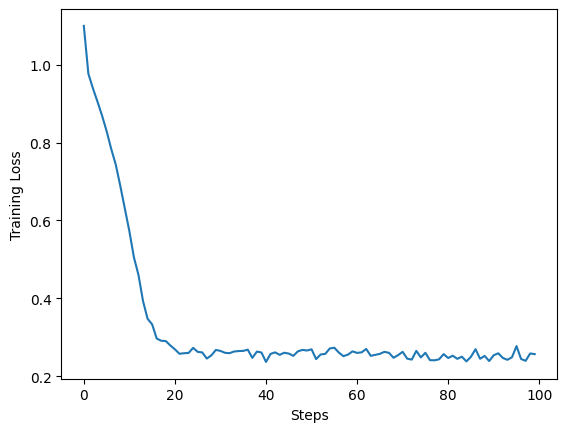

In [34]:
# Run experiment
configs = DEFAULT_REGDIFFUSION_CONFIGS
configs['verbose'] = True
configs['n_epoch'] = 100
configs['lr_adj'] = 1e-5
configs['eval_on_n_steps'] = 1
experiment_results['Microglia'] = run_cerebellum_experiment('Microglia', configs)

print(experiment_results['Microglia'])
# Training Plot
loss_plot = sns.lineplot(experiment_results['Microglia'].training_losses)
loss_plot.set(xlabel='Steps', ylabel='Training Loss')
plt.show()

In [9]:
with open('pathway/m2.cp.v2023.2.Mm.json', 'r') as f:
    cp = json.load(f)

In [30]:
with open('pathway/m5.go.v2023.2.Mm.json', 'r') as f:
    go = json.load(f)

In [54]:
pw_jaccard = []
for pw in tqdm(cp.keys(), total=len(cp)):
    pw_gene_set = set([
        g for g in cp[pw]['geneSymbols'] if 
        g in experiment_results['Microglia'].gene_names
    ])
    p_u_q = len(pw_gene_set) * (len(pw_gene_set)-1) 
    if p_u_q == 0:
        pw_jaccard.append({'pathway': pw, 'jaccard': 0})
    else:
        p_n_q = 0
        for gene in pw_gene_set:
            if gene in experiment_results['Microglia'].gene_names:
                gene_neighbor_df = experiment_results['Microglia'].extract_node_neighbors(
                    gene, k=20
                )
                for i, r in gene_neighbor_df.iterrows():
                    if r['Source'] in pw_gene_set and r['Target'] in pw_gene_set:
                        p_n_q += 1
        pw_jaccard.append({'pathway': pw, 'jaccard': p_n_q / p_u_q})

100%|██████████| 1701/1701 [01:41<00:00, 16.81it/s]


In [173]:
neighbor_dict = {}
for gene in tqdm(experiment_results['Microglia'].gene_names):
    neighbors = experiment_results['Microglia'].extract_node_neighbors(
                    gene, k=5
                )
    neighbor_dict[gene] = neighbors
    # neighbor_dict[gene]

100%|██████████| 10010/10010 [00:13<00:00, 767.32it/s]


In [191]:
from multiprocessing import Pool
from scipy.stats import hypergeom


inferred_genes = experiment_results['Microglia'].gene_names

def process_go(go_term):
    gene_set = set([
        g for g in go[go_term]['geneSymbols'] if 
        g in inferred_genes
    ])
    # gene_set = set(go[go_term]['geneSymbols'])
    all_nets_df = []
    for gene in gene_set:
        all_nets_df.append(neighbor_dict[gene])
    if len(all_nets_df) == 0:
        return {'go_term': go_term, 'p_value': 1,
            'TP': 0, 'FP': 0, 'P': 0, 
            'gene_set': gene_set, 'full_gene_set': go[go_term]['geneSymbols'], 
            'TP_set': set()}
    all_nets_df = pd.concat(all_nets_df)
    all_nets_df = all_nets_df.drop_duplicates()
    all_nets_df['Edge'] = all_nets_df['Source'] + ' -> ' + all_nets_df['Target']

    P = all_nets_df.shape[0]
    TP_set = set()
    FP_set_count = 0
    for i, r in all_nets_df.iterrows():
        if r['Source'] in gene_set and r['Target'] in gene_set:
            TP_set.add(r['Edge'])
        else:
            FP_set_count+=1

    M = len(inferred_genes) * (len(inferred_genes) - 1)
    n = len(gene_set) * (len(gene_set) - 1)
    N = P
    x = len(TP_set)
    
    p_value = hypergeom.sf(x-1, M, n, N)
    
    return {'go_term': go_term, 'p_value': p_value,
            'TP': len(TP_set), 'FP': FP_set_count, 'P': P, 
            'gene_set': gene_set, 'full_gene_set': go[go_term]['geneSymbols'], 
            'TP_set': TP_set}

if __name__ == '__main__':
   with Pool(6) as p:
      go_jaccard = list(tqdm(p.imap(process_go, go.keys()), total=len(go)))

100%|██████████| 10662/10662 [00:32<00:00, 326.99it/s]


In [196]:
go_jaccard = pd.DataFrame(go_jaccard)
# go_jaccard['TP'] = go_jaccard['TP_set'].map(len)
go_jaccard = go_jaccard.sort_values('p_value', ascending=True).reset_index()

In [197]:
go_jaccard['rank'] = go_jaccard.index + 1

In [198]:
go_jaccard['adjust_p'] = go_jaccard['p_value'] * go_jaccard['rank'] / go_jaccard.shape[0] 


In [199]:
go_jaccard.sort_values('adjust_p', ascending=True).reset_index()

ValueError: cannot insert level_0, already exists

In [200]:
go_jaccard.sort_values('adjust_p', ascending=True).head(60)

,level_0,index,go_term,p_value,TP,FP,P,gene_set,full_gene_set,TP_set,rank,adjust_p
9,2,148,GOBP_CELL_ACTIVATION,0.0,392,2692,3084,"{Ncaph2, Sh3rf1, H2-Oa, Stard7, Il4i1, Ldlr, P...","[6030468B19Rik, 9230019H11Rik, Abl1, Abl2, Abr...","{Sdc4 -> Ndfip1, Cfh -> Gsk3b, Il6 -> Havcr2, ...",10,0.0
41,1,4738,GOBP_POSITIVE_REGULATION_OF_CELLULAR_COMPONENT...,0.0,398,3368,3766,"{Fbxo4, Cdkn1b, Mecp2, Map3k4, Pacsin1, Il1rap...","[Abca1, Abca13, Abca3, Abca7, Abcb4, Abcb7, Ab...","{Atp8a2 -> Pip4k2a, Atl3 -> Rab31, Neu1 -> Kif...",42,0.0
40,28,7937,GOCC_MITOCHONDRION,0.0,687,5629,6316,"{Gng5, Abcb1b, Myo19, Fahd1, Smpd5, Ehhadh, Hi...","[1110017D15Rik, 1600014C10Rik, 1700066M21Rik, ...","{Acaca -> Tbc1d15, Fam72a -> Creb1, Mrps26 -> ...",41,0.0
39,29,81,GOBP_CELL_MORPHOGENESIS,0.0,310,2821,3131,"{Fryl, Ptpro, Fblim1, Mef2a, Mecp2, Alcam, Pac...","[Abi1, Abi2, Abi3bp, Abitram, Abl1, Abl2, Abli...","{Rock2 -> Myl12b, Map1s -> Dlg1, Csnk1a1 -> Ac...",40,0.0
15,59,6952,GOBP_REGULATION_OF_INTRACELLULAR_SIGNAL_TRANSD...,0.0,638,4198,4836,"{Fbxo4, Sh3rf1, Irak1, Tbk1, Dusp16, Ppia, Rap...","[1700037H04Rik, 3425401B19Rik, 4921509C19Rik, ...","{Acvr1 -> Hdac3, Fbxw11 -> Dgki, Ppp2cb -> Rho...",16,0.0
14,30,4708,GOBP_REGULATION_OF_TRANSPORT,0.0,684,4491,5175,"{Prkar1b, Kcnj9, Irak1, Glrx, Abcb1b, Kcnc3, C...","[1810037I17Rik, 4930550C14Rik, A1cf, Aacs, Aak...","{Nfe2l2 -> Mef2a, Srebf2 -> Pick1, Exoc2 -> Ep...",15,0.0
13,45,2490,GOBP_REGULATION_OF_PROTEIN_MODIFICATION_PROCESS,0.0,450,3795,4245,"{Fbxo4, Prkar1b, Sgf29, Ptpro, Irak1, Zbed3, C...","[2610042L04Rik, 2810408A11Rik, Abca2, Abi1, Ab...","{Acvr1 -> Hdac3, Sdc4 -> Ndfip1, Pkn1 -> Mycbp...",14,0.0
12,46,6041,GOBP_REGULATION_OF_RESPONSE_TO_STRESS,0.0,521,3841,4362,"{Fbxo4, Hspa8, Dpf3, Ly96, Prkar1b, Irak1, Sgf...","[A2m, Abca7, Abcb1a, Abcb1b, Abcc1, Abcd1, Abh...","{Dnmt3a -> Kdm6a, Smchd1 -> Mdfi, Parp14 -> St...",13,0.0
11,47,4488,GOBP_GENERATION_OF_NEURONS,0.0,566,4022,4588,"{Fryl, Sh3rf1, Ptpro, Secisbp2, Gak, Mef2a, Me...","[A830082K12Rik, AU040320, Abi1, Abi2, Abi3bp, ...","{Nfe2l2 -> Mef2a, Usp21 -> Mtr, Cfh -> Gsk3b, ...",12,0.0
10,48,4475,GOBP_NEURON_DEVELOPMENT,0.0,376,3407,3783,"{Fryl, Ptpro, Secisbp2, Gak, Mef2a, Mecp2, Rap...","[Abi1, Abi2, Abi3bp, Abitram, Abl1, Abl2, Abli...","{Nfe2l2 -> Mef2a, Usp21 -> Mtr, Cfh -> Gsk3b, ...",11,0.0


In [55]:
pw_jaccard = pd.DataFrame(pw_jaccard)
pw_jaccard.sort_values('jaccard', ascending=False).head(60)

,pathway,jaccard
29,BIOCARTA_CLASSIC_PATHWAY,2.000000
1564,WP_COMPLEMENT_ACTIVATION_CLASSICAL_PATHWAY,1.000000
580,REACTOME_METABOLISM_OF_ANGIOTENSINOGEN_TO_ANGI...,0.666667
438,REACTOME_INITIAL_TRIGGERING_OF_COMPLEMENT,0.600000
1482,REACTOME_ATORVASTATIN_ADME,0.500000
442,REACTOME_TRAFFICKING_AND_PROCESSING_OF_ENDOSOM...,0.232143
30,BIOCARTA_COMP_PATHWAY,0.200000
436,REACTOME_COMPLEMENT_CASCADE,0.170330
1641,WP_NUCLEAR_RECEPTORS_IN_LIPID_METABOLISM_AND_T...,0.089286
349,REACTOME_COLLAGEN_DEGRADATION,0.089286


In [25]:
pathway_gene_dict = {}
gene_pathway_dict = defaultdict(list)
for pw in cp.keys():
    pathway_gene_dict[pw] = cp[pw]['geneSymbols']
    for gene in cp[pw]['geneSymbols']:
        gene_pathway_dict[gene].append(pw)

In [36]:
go_gene_dict = {}
gene_go_dict = defaultdict(list)
for go_term in go.keys():
    go_gene_dict[go_term] = go[go_term]['geneSymbols']
    for gene in go[go_term]['geneSymbols']:
        gene_go_dict[gene].append(go_term)

In [15]:
gene_names = experiment_results['Microglia'].gene_names
gene_lower = gene_names.str.lower()

In [28]:
cp['BIOCARTA_RELA_PATHWAY']

{'collection': 'M2:CP:BIOCARTA',
 'systematicName': 'MM1339',
 'pmid': '',
 'exactSource': '',
 'externalDetailsURL': 'https://data.broadinstitute.org/gsea-msigdb/msigdb/biocarta/mouse/m_relaPathway.gif',
 'msigdbURL': 'https://www.gsea-msigdb.org/gsea/msigdb/mouse/geneset/BIOCARTA_RELA_PATHWAY',
 'geneSymbols': ['Chuk',
  'Crebbp',
  'Ep300',
  'Fadd',
  'Ikbkb',
  'Ikbkg',
  'Nfkb1',
  'Nfkbia',
  'Rela',
  'Ripk1',
  'Tnf',
  'Tnfrsf1a',
  'Tnfrsf1b',
  'Tradd',
  'Traf6'],
 'filteredBySimilarity': [],
 'externalNamesForSimilarTerms': []}

In [13]:
cp.keys()

dict_keys(['BIOCARTA_RELA_PATHWAY', 'BIOCARTA_CSK_PATHWAY', 'BIOCARTA_SRCRPTP_PATHWAY', 'BIOCARTA_ARAP_PATHWAY', 'BIOCARTA_AGR_PATHWAY', 'BIOCARTA_AKAP95_PATHWAY', 'BIOCARTA_AKT_PATHWAY', 'BIOCARTA_AT1R_PATHWAY', 'BIOCARTA_ACE2_PATHWAY', 'BIOCARTA_ASBCELL_PATHWAY', 'BIOCARTA_DNAFRAGMENT_PATHWAY', 'BIOCARTA_CHEMICAL_PATHWAY', 'BIOCARTA_ATM_PATHWAY', 'BIOCARTA_AGPCR_PATHWAY', 'BIOCARTA_BCELLSURVIVAL_PATHWAY', 'BIOCARTA_BLYMPHOCYTE_PATHWAY', 'BIOCARTA_BCR_PATHWAY', 'BIOCARTA_BIOPEPTIDES_PATHWAY', 'BIOCARTA_CACAM_PATHWAY', 'BIOCARTA_CDMAC_PATHWAY', 'BIOCARTA_CASPASE_PATHWAY', 'BIOCARTA_CBL_PATHWAY', 'BIOCARTA_CCR3_PATHWAY', 'BIOCARTA_CD40_PATHWAY', 'BIOCARTA_MCM_PATHWAY', 'BIOCARTA_G1_PATHWAY', 'BIOCARTA_G2_PATHWAY', 'BIOCARTA_CELL2CELL_PATHWAY', 'BIOCARTA_CERAMIDE_PATHWAY', 'BIOCARTA_CLASSIC_PATHWAY', 'BIOCARTA_COMP_PATHWAY', 'BIOCARTA_VDR_PATHWAY', 'BIOCARTA_HDAC_PATHWAY', 'BIOCARTA_GCR_PATHWAY', 'BIOCARTA_CTCF_PATHWAY', 'BIOCARTA_CTL_PATHWAY', 'BIOCARTA_CXCR4_PATHWAY', 'BIOCARTA_CELLCYC

In [20]:
adj_table = experiment_results['Microglia'].extract_node_neighborhood('Apoe', k=20, hop=2)   
adj_table.weight = adj_table.weight.map(lambda x: [0, 0.5, 1, 3][x])
adj_nx = nx.from_pandas_edgelist(adj_table, edge_attr='weight')
g=net.Network(notebook=True)
g.from_nx(adj_nx)
# options = 'var options = {"physics": {"solver": "forceAtlas2Based", "forceAtlas2Based": {"avoidOverlap": 0.0}}}'

# Set the options
# g.set_options(options)
g.repulsion()
g.show('test.html')

test.html


## Macrophage

/r/bcb/hao/miniconda3/envs/grn/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:248: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number
Training loss: 0.255: 100%|██████████| 200/200 [01:01<00:00,  3.23it/s]


Inferred GRN by {self.training_method}: 9,500 TFs x 9,500 Target Genes
 on 280 cells using RegDiffusion Time cost: 62 s


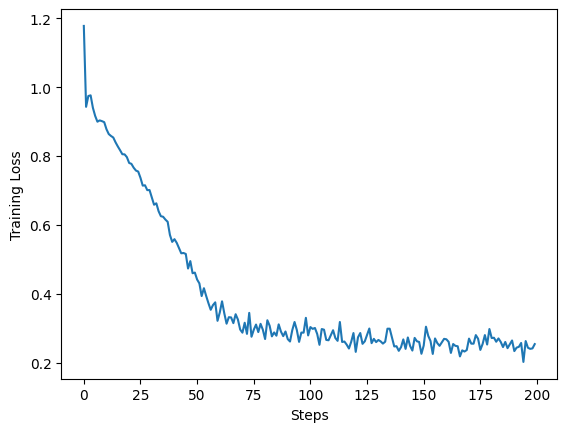

In [5]:
# Run experiment
configs = DEFAULT_REGDIFFUSION_CONFIGS
configs['verbose'] = True
configs['n_epoch'] = 200
configs['lr_adj'] = 1e-5
configs['eval_on_n_steps'] = 1
experiment_results['Macrophage'] = run_cerebellum_experiment('Macrophage', configs)

print(experiment_results['Macrophage'])
# Training Plot
loss_plot = sns.lineplot(experiment_results['Macrophage'].training_losses)
loss_plot.set(xlabel='Steps', ylabel='Training Loss')
plt.show()

# Saving adjacency list
experiment_results['Macrophage'].generate_adj_list(
    threshold=0.0003
).head(1000000).to_csv(
    'results/202401/Atlas_Macrophage_adjlist_top1M.csv', index=False
)

# Saving neighborhood plots
for gene in ['Apoe', 'Tmem176a', 'Ms4a6c']:
    adj_table = experiment_results['Microglia'].extract_node_neighborhood(gene, k=20, hop=2, threshold=0.0002)    
    adj_nx = nx.from_pandas_edgelist(adj_table)
    g=net.Network()
    g.from_nx(adj_nx)
    g.save_graph(f"results/202401/Atlas_Macrophage_{gene}.html")

/r/bcb/hao/miniconda3/envs/grn/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:248: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number
Training loss: 0.335: 100%|██████████| 30/30 [02:38<00:00,  5.27s/it]


Inferred GRN by {self.training_method}: 10,015 TFs x 10,015 Target Genes
 on 3989 cells using RegDiffusion Time cost: 158 s


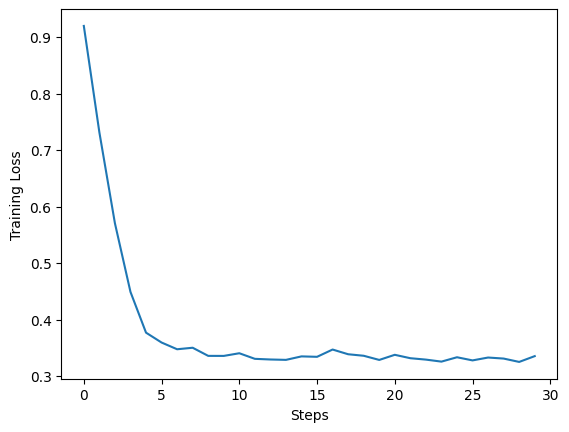

In [66]:
# Run experiment
configs = DEFAULT_REGDIFFUSION_CONFIGS
configs['verbose'] = True
configs['n_epoch'] = 30
configs['lr_adj'] = 1e-5
configs['eval_on_n_steps'] = 1
experiment_results['Golgi'] = run_cerebellum_experiment('Golgi', configs)

print(experiment_results['Golgi'])
# Training Plot
loss_plot = sns.lineplot(experiment_results['Golgi'].training_losses)
loss_plot.set(xlabel='Steps', ylabel='Training Loss')
plt.show()

# Hammond

In [ ]:
hammond_ann = sc.read_csv('../grnvae/data/other_data/Hammond_processed/final/male_p100_data.csv')
hammond_ann = hammond_ann.transpose()
hammond_ann = hammond_ann[:, ~hammond_ann.var_names.str.startswith('Gm')]
hammond_ann = hammond_ann[:, ~hammond_ann.var_names.str.startswith('mt')]
hammond_ann = hammond_ann[:, ~hammond_ann.var_names.str.startswith('Rpl')]
hammond_ann = hammond_ann[:, ~hammond_ann.var_names.str.startswith('Rps')]

sc.pp.filter_genes(hammond_ann, min_counts=10)
print(hammond_ann.shape)

configs = DEFAULT_REGDIFFUSION_CONFIGS
configs['verbose'] = True
configs['n_epoch'] = 40
configs['lr_adj'] = 1e-5
configs['eval_on_n_steps'] = 1

hammond_net = runRegDiffusion(hammond_ann.X, configs, 
                                gene_names = hammond_ann.var_names)

print(hammond_net)
# Training Plot
loss_plot = sns.lineplot(hammond_net.training_losses)
loss_plot.set(xlabel='Steps', ylabel='Training Loss')
plt.show()

# # Saving adjacency list
# hammond_net.generate_adj_list(
#     threshold=0.0003
# ).head(1000000).to_csv(
#     'results/202401/Hammond_Microglia_adjlist_top1M.csv', index=False
# )

# # Saving neighborhood plots
# for gene in ['Apoe', 'Tmem119', 'Selplg', 'Cx3cr1', 'P2ry12']:
#     adj_table = hammond_net.extract_node_neighborhood(gene, k=20, hop=2, threshold=0.0002)    
#     adj_nx = nx.from_pandas_edgelist(adj_table)
#     g=net.Network()
#     g.from_nx(adj_nx)
#     g.save_graph(f"results/202401/Hammond_Microglia_{gene}.html", )

/cluster/tufts/slonimlab/hzhu07/miniconda3/envs/grn/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:248: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number


(8259, 11484)


In [ ]:
hammond_net.inferred_adj[hammond_net.gene_indices['Ap4e1'], hammond_net.gene_indices['Ap4b1']]

In [59]:
all_edges 

,source,target,weight,score
0,Apoe,Lyz2,3,0.001067
1,Lyz2,Apoe,3,0.000650
2,Cd74,Apoe,3,0.000541
3,Apoe,B2m,3,0.000537
4,Apoe,Cd74,3,0.000502
...,...,...,...,...
277,Ftl1,Mt1,1,0.000373
278,Cd9,Mt1,1,0.000372
279,Mt1,Ctsa,1,0.000370
280,Mt1,Myeov2,1,0.000369


In [ ]:
adj_table = hammond_net.extract_node_neighborhood('Apoe', k=15, hop=2)   
adj_table.weight = adj_table.weight.map(lambda x: [0, 0.5, 1, 3][x])
adj_nx = nx.from_pandas_edgelist(adj_table, edge_attr='weight')
g=net.Network(notebook=True)
g.from_nx(adj_nx)
# options = 'var options = {"physics": {"solver": "forceAtlas2Based", "forceAtlas2Based": {"avoidOverlap": 0.0}}}'

# Set the options
# g.set_options(options)
g.repulsion()
g.show('test.html')

In [90]:
np.save('check', experiment_results['Microglia'].inferred_adj)

In [102]:
from scipy.sparse import csr_matrix, csc_matrix, coo_matrix, save_npz

In [110]:
adj_cut = experiment_results['Microglia'].inferred_adj.copy()

In [114]:
adj_cut[np.abs(adj_cut) < 0.0002] = 0

In [115]:
adj_cut_csr = csr_matrix(adj_cut)
# adj_cut_csc = csc_matrix(adj_cut)
# adj_cut_coo = coo_matrix(adj_cut)

In [123]:
np.sum(np.abs(adj_cut) < 0.0002) / adj_cut.shape[0] / adj_cut.shape[1]

0.9520724929416238

In [121]:
np.percentile(np.abs(adj_cut), 0.999999)

0.0

In [157]:
inferred_adj = experiment_results['Microglia'].inferred_adj

In [156]:
inferred_adj = experiment_results['Microglia'].inferred_adj
random_row_idx = np.random.randint(0, inferred_adj.shape[0], 10000)
random_col_idx = np.random.randint(0, inferred_adj.shape[1], 10000)

sampled_values = inferred_adj[random_row_idx, random_col_idx]
np.percentile(np.abs(sampled_values), 90)

0.0001674367769737728

In [163]:
inferred_adj = hammond_net.inferred_adj.copy()

In [165]:
random_row_idx = np.random.randint(0, inferred_adj.shape[0], 10000)
random_col_idx = np.random.randint(0, inferred_adj.shape[1], 10000)

sampled_values = inferred_adj[random_row_idx, random_col_idx]
cutoff = np.percentile(np.abs(sampled_values), 95)
inferred_adj[np.abs(inferred_adj) < cutoff] = 0

In [166]:
adj_t = inferred_adj.transpose()

In [167]:
adj_bw = np.concatenate([inferred_adj, adj_t], axis=1)

In [168]:
adj_bw_sparse = csr_matrix(adj_bw)

In [177]:
gene_connections_sparse = adj_bw_sparse[0, :]

In [180]:
np.argpartition(aaa.data, 20)

array([  19, 1267,   39, ...,    2, 1626,  813])

In [181]:
aaa.indices[np.argpartition(aaa.data, 20)]

array([  293, 18255,   587, ...,    28, 22942, 11243], dtype=int32)

In [170]:
save_npz('test', adj_bw_sparse)

In [11]:
import pickle
with open('trash', 'wb') as f:
    pickle.dump(experiment_results['Microglia'], f)

In [10]:
start = datetime.now()
experiment_results['Microglia'].extract_node_neighborhood('Apoe', k=20, hop=2)
end = datetime.now()
print((end - start).total_seconds())

0.06716


In [158]:
start = datetime.now()
hammond_net.extract_node_neighborhood('Apoe', k=20, hop=2)
end = datetime.now()
print((end - start).total_seconds())

0.076552


In [171]:
hammond_net[0, :]

TypeError: 'Inferred_GRN' object is not subscriptable

In [125]:
inferred_adj_flat = inferred_adj.flatten()

In [142]:
sampled_numbers = np.random.choice(inferred_adj_flat, 10000)
np.percentile(np.abs(sampled_numbers), 95)

0.00019746503239730372

In [129]:
random_r_idx = np.random.choice(inferred_adj.shape[0], 10000)

1.2405037680309761e-06

In [126]:
start = datetime.now()
inferred_adj_flat = inferred_adj.flatten()
end = datetime.now()
print((end - start).total_seconds())

0.163269


In [153]:
adj_table = hammond_net.extract_node_neighborhood('Apoe', k=20, hop=2, threshold=0.00014)    
adj_nx = nx.from_pandas_edgelist(adj_table)
g=net.Network(notebook=True)
g.from_nx(adj_nx)

for n in g.nodes:
    if n['id'] == 'Apoe':
        n['color'] = '#FF0000'
g.show('check.html')

# g.save_graph(f"results/202401/Hammond_Microglia_{gene}.html", )

check.html


In [89]:
adj_table = experiment_results['Microglia'].extract_node_neighborhood('B2m', k=15, hop=3, threshold=0.0002)    
adj_nx = nx.from_pandas_edgelist(adj_table)
g=net.Network(notebook=True)
g.from_nx(adj_nx)

for n in g.nodes:
    if n['id'] == 'B2m':
        n['color'] = '#FF0000'
g.show_buttons()
g.show('check.html')

# g.save_graph(f"results/202401/Hammond_Microglia_{gene}.html", )

check.html


In [88]:
g.nodes

[{'color': '#97c2fc',
  'size': 10,
  'id': 'Cst3',
  'label': 'Cst3',
  'shape': 'dot'},
 {'color': '#97c2fc', 'size': 10, 'id': 'B2m', 'label': 'B2m', 'shape': 'dot'},
 {'color': '#97c2fc',
  'size': 10,
  'id': 'C1qa',
  'label': 'C1qa',
  'shape': 'dot'},
 {'color': '#97c2fc',
  'size': 10,
  'id': 'C1qb',
  'label': 'C1qb',
  'shape': 'dot'},
 {'color': '#97c2fc',
  'size': 10,
  'id': 'C1qc',
  'label': 'C1qc',
  'shape': 'dot'},
 {'color': '#97c2fc',
  'size': 10,
  'id': 'Ctsd',
  'label': 'Ctsd',
  'shape': 'dot'},
 {'color': '#97c2fc',
  'size': 10,
  'id': 'Cd81',
  'label': 'Cd81',
  'shape': 'dot'},
 {'color': '#97c2fc',
  'size': 10,
  'id': 'Ctss',
  'label': 'Ctss',
  'shape': 'dot'},
 {'color': '#97c2fc',
  'size': 10,
  'id': 'Itm2b',
  'label': 'Itm2b',
  'shape': 'dot'},
 {'color': '#97c2fc',
  'size': 10,
  'id': 'Hexb',
  'label': 'Hexb',
  'shape': 'dot'},
 {'color': '#97c2fc',
  'size': 10,
  'id': 'Tmsb4x',
  'label': 'Tmsb4x',
  'shape': 'dot'},
 {'color': '#9

In [70]:
adj_table = experiment_results['Golgi'].extract_node_neighborhood('Creb3', k=20, hop=2, threshold=0.0002)    
adj_nx = nx.from_pandas_edgelist(adj_table)
g=net.Network(notebook=True)
g.from_nx(adj_nx)
g.show('check.html')
# g.save_graph(f"results/202401/Hammond_Microglia_{gene}.html", )

check.html


In [52]:
import pickle

In [54]:
with open('results/202401/all_exps.pkl', 'wb') as f:
    pickle.dump((experiment_results, hammond_net), f)

In [49]:
def compare_similarity(res1, res2):
    res1_mask = np.array([i for i, g in enumerate(res1.gene_names) if g in res2.gene_names])
    res2_mask = np.array([i for i, g in enumerate(res2.gene_names) if g in res1.gene_names])
    res1_shared_adj = res1.inferred_adj[res1_mask, :][:, res1_mask]
    res2_shared_adj = res2.inferred_adj[res2_mask, :][:, res2_mask]
    cosine_similarity = torch.cosine_similarity(
        torch.tensor(res1_shared_adj),
        torch.tensor(res2_shared_adj)
    ).mean().item()
    return cosine_similarity

In [50]:
compare_similarity(hammond_net, experiment_results['Microglia'])

0.4537639319896698

In [51]:
compare_similarity(hammond_net, experiment_results['Macrophage'])

0.37204214930534363

In [18]:
res1 = experiment_results['Microglia']
res2 = experiment_results['Macrophage']

In [61]:
compare_similarity(experiment_results['Fibroblast'], hammond_net)

0.5110369324684143

In [16]:
import torch

In [40]:
torch.cosine_similarity(
    torch.tensor(res1_shared_adj),
    torch.tensor(res2_shared_adj)
).mean().item()

0.36666497588157654